This code generates the model SNe for each model type. 

Check up on Model 4, I think the mixed map has a normalization error. (map built in SNeCO/3.4cModelVisualization)

In [1]:
#import packages and initialize settings
import time
import os
import numpy as np
from astropy.io import fits, ascii
import astropy.io.fits as pyfits
from astropy.wcs import WCS
from matplotlib import pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join
from reproject import reproject_interp
import aplpy
import scipy
from scipy.interpolate import interp1d

plt.rc('text',usetex=True)
fontsize=20
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

import sys
sys.path.append('./Python')
from nearest import findNearest
from deprojectGalaxy import deproject
from SNeGenerationModels import runModels
from getMapValue import getValue

In [2]:
imgName = "SFRcopt"
ext = "HA_FLUX_CORR"


#Get Galaxy names, distances, and fits file locations

# Unpack master table to get SNe information
GalaxyData = Table.read('../Data/0.MUSEData.csv', format='csv')
SampleData = Table.read('../Data/2.MUSESampleCat.csv', format='csv') 
SampleData.remove_column("Distance")
SampleData.remove_column("MUSENatMap")
SampleData.remove_column("MUSE150pcMap")
SampleData.remove_column("MUSEHII")
SampleData.remove_column("MUSERes")
SampleData.remove_column("IRACfiles")
SampleData.remove_column("Incl")
SampleData.remove_column("coptMap")

database = join(GalaxyData, SampleData, keys = "Galaxy", join_type = 'inner')
centerCoords = [(database["GalRa"][i], database["GalDec"][i]) for i in range(len(database))]   

database[0:8]


Galaxy,Distance,GalRa,GalDec,PosAng,Incl,MUSENatRes,MUSEPhysRes,MUSEmapNat,MUSEmap150pc,MUSE_HII_reg,IRAC_files,SFRcopt,SFR15asec,Supernova,Type,Ra,Dec,Intensity,InSample
str7,float64,float64,float64,float64,float64,float64,int64,str71,str70,str50,str40,str58,str60,str11,str12,float64,float64,float64,str4
NGC1087,15.85,41.60492,-0.498717,359.1,42.9,0.92,84,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1087-0.92asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1087-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1087_nebulae_mask_V2.fits,../Data/IRAC/ngc1087_irac1_atGauss4.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1087_sfr.fits,../../GalaxyFiles/MUSELargeFiles/SFR/15asec/NGC1087_sfr.fits,SN1995V,II,41.61152777777777,-0.4987861111111111,8.839672735197591e+39,True
NGC1300,18.99,49.920815,-19.411114,278.0,31.8,0.89,83,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1300-0.89asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1300-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1300_nebulae_mask_V2.fits,../Data/IRAC/ngc1300_irac1_atGauss4.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1300_sfr.fits,../../GalaxyFiles/MUSELargeFiles/SFR/15asec/NGC1300_sfr.fits,SN2022acko,II,49.91245833333333,-19.39518888888889,3.445745101042276e+38,True
NGC1365,19.57,53.40152,-36.140404,201.1,55.4,1.15,76,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1365_sfr.fits,../../GalaxyFiles/MUSELargeFiles/SFR/15asec/NGC1365_sfr.fits,SN2012fr,Ia,53.40057916666666,-36.12676944444445,8.904660571183651e+37,True
NGC1365,19.57,53.40152,-36.140404,201.1,55.4,1.15,76,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1365_sfr.fits,../../GalaxyFiles/MUSELargeFiles/SFR/15asec/NGC1365_sfr.fits,SN2001du,II,53.3713125,-36.142111111111106,1.3530435354080875e+39,True
NGC1365,19.57,53.40152,-36.140404,201.1,55.4,1.15,76,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1365_sfr.fits,../../GalaxyFiles/MUSELargeFiles/SFR/15asec/NGC1365_sfr.fits,SN1983V,Ic,53.381876388888884,-36.14859166666667,1.4845660990817182e+40,True
NGC1365,19.57,53.40152,-36.140404,201.1,55.4,1.15,76,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1365_sfr.fits,../../GalaxyFiles/MUSELargeFiles/SFR/15asec/NGC1365_sfr.fits,SN1957C,Unclassified,53.38349999999999,-36.11770833333333,2.938518960212585e+39,True
NGC1433,18.63,55.506195,-47.221943,199.7,28.6,0.91,69,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1433-0.91asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1433-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1433_nebulae_mask_V2.fits,../Data/IRAC/ngc1433_irac1_atGauss4.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1433_sfr.fits,../../GalaxyFiles/MUSELargeFiles/SFR/15asec/NGC1433_sfr.fits,SN1985P,II,55.52640625,-47.209987222222225,2.4790371281538853e+38,True
NGC1566,17.69,65.00159,-54.93801,214.7,29.5,0.8,80,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1566-0.80asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1566-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1566_nebulae_mask_V2.fits,../Data/IRAC/ngc1566_irac1_atGauss4.fits,../../GalaxyFile

In [3]:
# Functions
def angDistToPc(x,galDist):
    return(galDist*10**6*np.tan(x*np.pi/180))

def nearestHII(galaxy, HII_file, centerCoord, pa, incl, galDist, SNra, SNdec):
    HII_val = []
    if os.path.isfile(HII_file):

        # read in fits files
        hdu_HII = pyfits.open(HII_file)
        HIIMap  = hdu_HII[0].data

        #Convert x & y pixels to ra and dec
        wcs      = WCS(hdu_HII[0].header, naxis=2)
        naxis    = wcs._naxis # size of image naxis[0] = x and [1] = y
        grid     = np.indices((naxis[1],naxis[0]))
        ra, dec  = wcs.wcs_pix2world(grid[1],grid[0],0)

        #deproject ra and dec to dx and dy
        radius, projang, dx, dy = deproject(center_coord=centerCoord, incl=incl, pa=pa, ra=ra, dec=dec, return_offset=True)

        # Get the value from the HII map at the SN location
        pix_x, pix_y = wcs.wcs_world2pix(SNra, SNdec, 0, ra_dec_order=True)
        pix_x = [int(x) for x in pix_x]
        pix_y = [int(x) for x in pix_y]
        
        for i in range(len(SNra)):
            HII_val.append(HIIMap[pix_y[i], pix_x[i]])

        
        #flatten data structures 
        f_HII  = HIIMap.flatten()
        f_ra   = ra.flatten()
        f_dec  = dec.flatten()    
        f_dx   = dx.flatten()
        f_dy   = dy.flatten()

        #remove nans
#         keep  = np.where(np.isfinite(f_HII))
        keep  = np.where(f_HII >= 0)
        map_ra    = f_ra[keep]
        map_dec   = f_dec[keep]
        map_HII   = f_HII[keep]
        map_dx    = f_dx[keep]
        map_dy    = f_dy[keep]

        SN_Rad, SN_PA, SN_dx, SN_dy = deproject(center_coord=centerCoord, incl=incl, pa=pa, ra=SNra, dec=SNdec, return_offset=True) 
        
        nearestHII_ang, idx = findNearest(map_dx, SN_dx, map_dy, SN_dy)
        HIIra, HIIdec = map_ra[idx], map_dec[idx]
        nearestHII_pc = angDistToPc(nearestHII_ang,galDist)
        
        #Check if the SN is in an HII region and adjust nearest HII region value accordingly
        for i in range(len(SNra)):
            if HII_val[i] > 0:
                nearestHII_pc[i] = 0.
        
#         print("Nearest HII region [pc]", nearestHII_pc, galaxy)

    else:
        print("No file for ", galaxy)

        nearestHII_pc = float("nan")
        HIIra = float("nan")
        HIIdec = float("nan")
        
    return(nearestHII_pc, HIIra, HIIdec)


In [4]:
#group sample by galaxy
gal_groups = database.group_by('Galaxy')
galaxies = gal_groups.groups.keys
indices = gal_groups.groups.indices
indices = indices.tolist()
indices.append(0)

gs, imgs, HIIimgs,IRACimgs, names, types, ras, decs, dists, res = [],[],[],[],[],[],[],[],[],[]
galRa,galDec,galPA,galIncl = [],[],[],[]

for i in range(len(indices)-2):
    SNnames, SNtypes, SNras, SNdecs = [],[],[],[]
    gs.append(gal_groups["Galaxy"][indices[i]])
    imgs.append(gal_groups[imgName][indices[i]])
    HIIimgs.append(gal_groups["MUSE_HII_reg"][indices[i]])
    IRACimgs.append(gal_groups["IRAC_files"][indices[i]])
    dists.append(gal_groups["Distance"][indices[i]])
    res.append(gal_groups["MUSENatRes"][indices[i]])
    galRa.append(gal_groups["GalRa"][indices[i]])
    galDec.append(gal_groups["GalDec"][indices[i]])
    galPA.append(gal_groups["PosAng"][indices[i]])
    galIncl.append(gal_groups["Incl"][indices[i]])
    
    #if gal_groups["SN_name"][indices[i]] != "SN1989B" and gal_groups["SN_name"][indices[i]] != "SN1973R":
    # Attach first SN per galaxy to a list
    SNnames.append(gal_groups["Supernova"][indices[i]])
    SNtypes.append(gal_groups["Type"][indices[i]])
    SNras.append(gal_groups["Ra"][indices[i]])
    SNdecs.append(gal_groups["Dec"][indices[i]])
    j = 1
    # attach additional  SN to list when galaxy has more than one
    while(indices[i] + j < indices[i+1]):    
        #if gal_groups["SN_name"][indices[i]+j] != "SN1989B" and gal_groups["SN_name"][indices[i]+j] != "SN1973R":
        SNnames.append(gal_groups["Supernova"][indices[i]+j])
        SNtypes.append(gal_groups["Type"][indices[i]+j])
        SNras.append(gal_groups["Ra"][indices[i]+j])
        SNdecs.append(gal_groups["Dec"][indices[i]+j])
        j += 1
    names.append(SNnames)
    types.append(SNtypes)
    ras.append(SNras)
    decs.append(SNdecs)

print(gs)
print(ras)

['NGC1087', 'NGC1300', 'NGC1365', 'NGC1433', 'NGC1566', 'NGC1672', 'NGC3627', 'NGC4254', 'NGC4303', 'NGC4321']
[[41.61152777777777], [49.91245833333333], [53.40057916666666, 53.3713125, 53.381876388888884, 53.38349999999999], [55.52640625], [64.9725, 64.99512499999999, 65.0058875], [71.423975, 71.45607916666667], [170.04809375, 170.05796666666666, 170.07957933333336, 170.07072916666667, 170.0592513888889], [184.71836111111114, 184.71066666666667, 184.71690625, 184.70291666666668], [185.48760972222217, 185.47536458333335, 185.50184583333336, 185.4698125, 185.46016458333332, 185.48041875, 185.48991666666666], [185.72488194444443, 185.74543194444445, 185.6970833333333, 185.72892708333336, 185.73393055555553]]


In [5]:
    
# # run models 1-4 and store results
galCol, counter, int_mod1, int_mod2, int_mod3, near_mod1, near_mod2, near_mod3 = [],[],[],[],[],[],[],[]
HaTot, HaHII, SDTot, SDHII = [],[],[],[]
HaPix, HaHIIPix, SDPix, SDHIIPix = [],[],[],[]


for i in range(len(gs)):
# for i in range(0,1):
#     i = 8
    
    # Using MUSE map for coverage and to measure H-alpha emission
    img_hdu = pyfits.open(imgs[i])
    img_map = img_hdu[ext].data
    
    #Get IRAC maps to look at the stellar populations emission
    IRAC_hdu = pyfits.open(IRACimgs[i])
    IRAC_map = IRAC_hdu[0].data
    
    #Get HII regions masks
    hdu_HII = pyfits.open(HIIimgs[i])
    HIIMap  = hdu_HII[0].data    
    
    # Reproject IRAC maps
    IRAC_repro, IRAC_foot = reproject_interp(IRAC_hdu, img_hdu[ext].header)

    #Convert x & y pixels to ra and dec
    wcs      = WCS(hdu_HII[0].header, naxis=2)
    naxis    = wcs._naxis # size of image naxis[0] = x and [1] = y
    grid     = np.indices((naxis[1],naxis[0]))
    ra, dec  = wcs.wcs_pix2world(grid[1],grid[0],0)
            
    #flatten data structures 
    f_HII  = HIIMap.flatten()
    f_ra   = ra.flatten()
    f_dec  = dec.flatten()    
    f_img = img_map.flatten()
    f_IRAC = IRAC_repro.flatten() 
    
    #remove nans
    keep = np.where(np.isfinite(f_img) & np.isfinite(f_IRAC))
    map_HII  = f_HII[keep]
    map_IRAC = f_IRAC[keep]
    map_img  = f_img[keep]  
    
    # sum up the total emission
    HaPix.append(len(map_img))
    SDPix.append(len(map_IRAC))
    HaTot.append(np.sum(map_img))
    SDTot.append(np.sum(map_IRAC))
    
    # Isolate HII regions
    keep  = np.where(map_HII >= 0)
    map_HII  = map_HII[keep]
    map_IRAC = map_IRAC[keep]
    map_img  = map_img[keep]
    
    # sum up the HII region emission
    HaHIIPix.append(len(map_img))
    SDHIIPix.append(len(map_IRAC))
    HaHII.append(np.sum(map_img))
    SDHII.append(np.sum(map_IRAC))   
    
    # get maps with real values for models
#     keep = np.where(np.isfinite(f_img))
    keep = np.where(np.isfinite(f_img) & np.isfinite(f_IRAC))
    IRAC      = f_IRAC[keep]
    star_ra   = f_ra[keep]
    star_dec  = f_dec[keep]
    
    
    raArr1, decArr1, dxArr1, dyArr1, intArr1 = runModels(gs[i], imgs[i], ext, centerCoords[i], galPA[i], galIncl[i], dists[i], modelType=1)
    raArr2, decArr2, dxArr2, dyArr2, intArr2 = runModels(gs[i], imgs[i], ext, centerCoords[i], galPA[i], galIncl[i], dists[i], modelType=2)
    raArr3, decArr3, dxArr3, dyArr3, intArr3 = runModels(gs[i], imgs[i], ext, centerCoords[i], galPA[i], galIncl[i], dists[i], modelType=3, starLight = IRAC, starRa = star_ra, starDec = star_dec)

    n_mod1_dist, n_mod1_ra, n_mod1_dec = nearestHII(gs[i], HIIimgs[i], centerCoords[i], galPA[i], galIncl[i], dists[i], raArr1, decArr1)
    n_mod2_dist, n_mod2_ra, n_mod2_dec = nearestHII(gs[i], HIIimgs[i], centerCoords[i], galPA[i], galIncl[i], dists[i], raArr2, decArr2)
    n_mod3_dist, n_mod3_ra, n_mod3_dec = nearestHII(gs[i], HIIimgs[i], centerCoords[i], galPA[i], galIncl[i], dists[i], raArr3, decArr3)

    
    if (type(n_mod1_dist) != float and type(n_mod1_dist) != np.float64):
        for j in range(len(n_mod1_dist)):
            galCol.append(gs[i])
            counter.append(j)
            near_mod1.append(n_mod1_dist[j])
            near_mod2.append(n_mod2_dist[j])
            near_mod3.append(n_mod3_dist[j])
    else:
        for j in range(1000):
            galCol.append(gals[i])
            counter.append(j)
            near_mod1.append(np.float('nan'))
            near_mod2.append(np.float('nan'))
            near_mod3.append(np.float('nan'))
            
    intArr1    = np.nan_to_num(np.clip(intArr1,0,np.max(intArr1)))
    intArr2    = np.nan_to_num(np.clip(intArr2,0,np.max(intArr2)))
    intArr3    = np.nan_to_num(np.clip(intArr3,0,np.max(intArr3)))
    
    int_mod1.append(intArr1)
    int_mod2.append(intArr2)
    int_mod3.append(intArr3)
    
int_mod1 = np.hstack(int_mod1)
int_mod2 = np.hstack(int_mod2)
int_mod3 = np.hstack(int_mod3)
    
results = Table({"Galaxy": galCol,
                "ModelNum": counter,
                "near_Mod1_dist": near_mod1,
                "near_Mod2_dist": near_mod2,
                "near_Mod3_dist": near_mod3,
                "intMod1":int_mod1,
                "intMod2":int_mod2,
                "intMod3":int_mod3})

results.write("../Data/AllModels.csv", format = "csv", overwrite = True)

        
        
    

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
r_int: [9.43212662e+

r_int: [3.53252222e+39 1.53489150e+40 1.63300143e+41 6.94045329e+40
 8.10472601e+39 1.45210151e+40 9.62893449e+39 1.74920666e+39
 1.33804158e+39 9.11152857e+38 2.58295338e+39 4.94884241e+39
 2.09615207e+39 2.29678056e+41 1.97566444e+40 4.08126056e+40
 1.54006343e+41 3.41861826e+39 2.33843635e+39 1.11391774e+40
 4.71639799e+40 3.15618161e+40 1.75607623e+39 1.60980852e+41
 1.25577248e+40 2.75904488e+39 2.57143812e+39 3.15704446e+40
 4.09839276e+38 3.75182313e+38 5.45772340e+39 1.00052838e+40
 1.07080088e+41 3.51404765e+39 7.19455407e+40 3.04708374e+40
 8.05606181e+38 3.38055699e+38 4.58601410e+41 1.05472333e+40
 2.04645356e+39 2.99136528e+39 1.44173798e+41 1.38008893e+40
 2.15648889e+41 6.17339684e+40 9.75861359e+39 2.52851419e+39
 3.29547976e+40 3.29494784e+40 6.59635487e+40 8.01289158e+39
 1.37015507e+40 1.19909617e+40 4.90481340e+40 1.02628729e+40
 3.08357700e+39 4.34219167e+40 3.02362893e+40 6.42415811e+40
 7.93099316e+39 5.13462455e+39 3.47120819e+40 1.44020503e+39
 5.76802715e+37 5

r_int: [8.68638687e+38 6.75037255e+38 4.36222986e+39 9.49292621e+40
 2.90405118e+40 7.61120928e+39 1.05827029e+40 1.45070165e+39
 1.48956915e+41 6.09049410e+40 3.43585200e+38 9.37637646e+37
 3.99078445e+39 9.34204943e+38 3.03661313e+39 5.88108393e+39
 6.42644011e+38 2.00235547e+39 3.04980378e+39 1.43887695e+37
 3.63334361e+39 1.48039959e+39 2.08154813e+39 2.22335286e+39
 3.92182864e+39 2.10941669e+40 1.34360427e+39 2.04908308e+38
 9.98322258e+39 3.13097156e+39 9.22116462e+38 1.79849520e+38
 9.04963467e+38 4.35649429e+39 5.39450390e+38 5.69149748e+38
 1.90394663e+38 7.08242412e+39 6.89607589e+39 3.61716797e+39
 3.91525193e+38 4.56604656e+37 5.73743890e+38 5.42530245e+38
 4.35157893e+38 3.18160518e+38 2.91811700e+37 1.18274155e+39
 1.75423645e+38 1.94453087e+39 1.17391151e+41 5.09104251e+39
 6.90556404e+38 4.18674496e+39 1.92935195e+39 6.97196940e+37
 2.98426034e+37 4.09825640e+38 6.45246384e+38 2.47906725e+39
 2.34621268e+39 8.17182752e+38 5.28928998e+39 9.64477012e+37
 2.58843220e+39 5

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
r_int: [7.81387342e+

r_int: [3.69816035e+38 3.75829808e+39 7.30050468e+39 1.17554151e+39
 1.98181338e+39 4.82278259e+40 1.39219155e+39 2.44990697e+38
 1.37970779e+40 2.29116783e+40 6.70359611e+39 6.38858200e+37
 1.84629629e+40 5.79638486e+38 7.20530321e+39 4.30302014e+38
 1.33413763e+39 9.00402209e+38 1.92219299e+39 7.21493263e+40
 7.84141248e+38 1.23981191e+40 2.88992905e+38 1.07898362e+40
 2.58574717e+40 2.86230709e+39 6.86196682e+40 3.70544149e+39
 5.59415878e+38 1.68234163e+40 2.93254721e+39 3.69252448e+39
 1.42034397e+40 3.00166619e+40 1.44881034e+39 1.13831451e+41
 1.95552187e+41 4.57520294e+39 6.06008645e+39 9.17800372e+39
 3.57097694e+38 3.40042946e+38 1.82703121e+40 9.86750156e+38
 1.03963047e+40 5.16499539e+38 4.93949209e+37 7.19505034e+39
 1.19989057e+39 4.70205367e+40 3.24766067e+40 7.16965767e+38
 1.89559221e+39 8.56440328e+39 1.06239117e+39 2.89109837e+40
 9.61677341e+39 9.31232666e+39 1.07263318e+37 6.71199250e+39
 1.67297680e+38 7.22105541e+39 5.74366968e+39 2.61513949e+39
 1.78740218e+40 3

r_int: [5.15818419e+37 1.05694056e+38 9.00624833e+37 5.53714460e+37
 2.18445782e+38 1.36250810e+37 5.32775897e+38 2.84444828e+37
 6.65784867e+37 2.09022820e+38 5.69784503e+37 2.70935961e+37
 9.26155305e+37 1.01826839e+38 3.78596268e+37 1.02377036e+40
 2.52313260e+37 8.09508730e+37 1.52928317e+38 2.29624224e+38
 1.64471458e+39 4.78147572e+37 9.63320961e+38 2.52288720e+39
 1.72992052e+37 1.64061773e+38 9.66725475e+36 5.65769319e+37
 3.92044099e+39 7.05925301e+37 5.41601849e+37 3.29221685e+37
 3.88955211e+40 7.21346635e+37 2.58814255e+38 3.91742215e+37
 3.52288420e+38 3.01031014e+38 3.29488001e+37 1.81241389e+39
 7.82057376e+39 1.19853505e+39 6.51596983e+39 5.02126682e+37
 1.23065119e+39 6.83253670e+37 6.46209269e+37 4.76849167e+37
 2.17317917e+37 1.04640320e+38 5.94690211e+38 1.35594074e+40
 4.42999667e+39 5.03476022e+38 4.83491033e+37 4.29577397e+37
 3.68392647e+37 4.33390784e+40 2.27094789e+38 4.48866792e+37
 2.62697548e+37 3.29150950e+38 2.43983210e+37 7.86053231e+38
 2.53159237e+36 2

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
r_int: [3.52818605e+

r_int: [1.89532364e+42 9.13945448e+39 7.36073483e+39 2.92991361e+40
 9.99816720e+38 1.57546842e+40 5.22368694e+41 1.24072916e+41
 3.52404123e+41 1.08575259e+41 4.01748193e+41 7.60664090e+38
 3.86926636e+38 2.10484231e+41 4.17141983e+38 1.40553045e+41
 1.71841733e+40 1.85459870e+41 2.78093859e+39 8.17783221e+40
 5.31856275e+41 4.49732090e+41 1.58988376e+41 3.94033871e+41
 3.06209160e+41 4.70780448e+41 7.09340486e+39 2.05052545e+41
 1.64234815e+42 1.25039348e+41 4.03292636e+41 1.12912524e+41
 2.46260094e+39 5.06390105e+40 2.62034585e+40 3.08609335e+41
 2.11535828e+41 1.17044636e+41 1.04257572e+40 1.92668871e+39
 4.79079900e+40 2.11859698e+41 3.47746023e+41 2.35502696e+38
 3.38079723e+41 6.05649734e+40 8.90805482e+41 3.69330218e+41
 3.51328370e+41 1.82862976e+41 1.95368431e+41 1.75447092e+39
 3.48053962e+41 6.33817477e+40 2.09632078e+39 3.12618770e+42
 3.29537238e+41 3.83336389e+41 5.47754435e+40 3.74529453e+40
 6.80464538e+40 1.05786199e+41 3.71532489e+41 7.42780576e+38
 3.63975410e+41 3

r_int: [7.36271462e+37 5.16661280e+39 1.05822685e+39 1.02392204e+41
 2.77313658e+39 1.03295182e+40 5.82616644e+38 7.56921547e+40
 5.21945295e+41 2.56451157e+41 6.43702575e+39 1.65994697e+39
 1.49257302e+39 8.95746486e+40 7.85070010e+37 1.11618473e+38
 1.07795131e+38 2.62647950e+41 5.63856649e+37 6.58947007e+38
 7.32992017e+38 3.74914868e+38 6.87689368e+37 7.05081912e+37
 5.04448509e+40 9.61423455e+38 8.44964142e+41 4.71889014e+39
 2.52018339e+41 6.34711381e+38 3.31545232e+40 2.45460692e+40
 3.46873697e+38 1.37704330e+40 2.70557231e+40 5.72016058e+37
 6.65520885e+38 4.12663315e+41 6.44733416e+39 4.53862355e+37
 1.71549559e+39 2.92988355e+39 1.03487111e+39 2.21563587e+38
 5.65964772e+38 5.83887900e+40 3.25389531e+39 2.87948656e+40
 3.89743703e+38 3.83201932e+40 1.09031692e+41 3.32837365e+40
 5.42862174e+38 6.52501806e+38 5.23359897e+40 2.96514342e+38
 1.65029207e+40 1.56014065e+39 5.29053174e+39 1.57283518e+38
 3.34611629e+39 3.69524815e+38 3.70980001e+40 5.68491421e+40
 1.08631799e+39 2

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
r_int: [4.12374910e+

r_int: [1.29478219e+40 3.56746496e+39 2.37493421e+38 3.13603661e+39
 9.12052170e+37 4.32058850e+38 6.60409166e+38 7.87655109e+40
 1.20907032e+39 1.65887084e+38 1.25188556e+38 1.03706947e+39
 2.22181136e+41 5.29920611e+39 1.17840330e+40 4.98239659e+39
 4.50044399e+39 1.46081834e+40 1.89541277e+40 9.21142641e+37
 1.45304462e+39 2.22108074e+41 1.80158542e+39 1.90704164e+39
 1.28329894e+37 2.61695160e+39 2.43047650e+39 2.21474264e+38
 7.67884629e+38 2.60182854e+41 1.40169185e+40 1.42128619e+39
 7.98676936e+37 5.09803326e+37 1.85941134e+38 1.22471508e+39
 4.45533429e+39 1.13147993e+41 9.28582978e+38 1.84008280e+38
 2.23637699e+39 1.09175013e+39 1.92482749e+39 1.26024222e+37
 5.96111382e+39 2.01118049e+39 2.18314913e+40 3.08539322e+39
 2.87305929e+37 4.67612181e+37 8.64732417e+38 7.47573497e+37
 5.55019212e+39 1.43375745e+39 3.50922006e+39 1.95945968e+39
 2.57130738e+40 1.77687138e+39 4.45848950e+38 2.17195144e+39
 3.95374762e+40 3.62483152e+38 6.17567968e+39 2.27951796e+39
 1.66493252e+40 1

r_int: [1.57419158e+38 3.00161100e+37 4.57050271e+39 2.22510464e+37
 3.52697874e+37 7.50277535e+38 1.05201792e+38 1.68656374e+37
 3.38017562e+38 1.02167767e+40 1.39378495e+38 1.25455603e+38
 6.69111184e+39 1.58149634e+39 2.40892442e+40 1.38177315e+37
 1.12020466e+40 3.28418662e+38 3.49943309e+37 3.42871464e+39
 3.12384588e+38 2.11511412e+39 6.69701992e+37 7.73777859e+39
 9.58189824e+37 2.59700667e+37 7.06402879e+38 3.94119949e+37
 8.03277649e+37 2.19227766e+37 1.94499715e+39 1.71726496e+38
 1.40751172e+37 7.73886492e+37 7.59169779e+37 5.29056572e+39
 3.48918022e+37 4.27083503e+39 1.23497357e+40 1.03896708e+38
 4.10680007e+37 3.06105959e+37 4.70768481e+39 1.99628310e+37
 2.19866018e+40 3.80935477e+37 1.88523196e+38 3.66433739e+38
 2.17072032e+39 8.23609393e+37 3.27821366e+37 8.54664285e+37
 8.10241446e+37 1.71388110e+38 4.30402673e+37 6.60721513e+38
 2.81066145e+37 1.70350528e+38 3.97282766e+37 8.59737824e+37
 2.56541526e+37 3.64582802e+38 1.50356646e+38 6.99981830e+39
 4.71194809e+37 1

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
r_int: [1.50834722e+

r_int: [4.83571460e+40 1.55316146e+40 8.67921224e+40 1.01977717e+39
 1.89800705e+40 4.02288152e+40 1.64410027e+41 6.77877978e+40
 2.52406478e+40 2.34859923e+39 3.99642169e+39 1.90558211e+40
 4.98606433e+39 2.42517124e+40 3.33579302e+39 2.44519548e+39
 9.08705776e+38 1.03487328e+40 2.00631039e+40 5.03396065e+40
 8.48975906e+38 1.27286158e+40 6.91400884e+40 2.81339797e+39
 2.50229605e+40 1.07630559e+40 1.68911241e+40 4.15290356e+38
 2.20972548e+39 1.43060669e+40 3.24912632e+39 9.79815483e+37
 8.27278089e+39 9.47528815e+40 1.46214610e+41 3.39540706e+38
 6.45589033e+38 1.75956128e+38 2.53655627e+40 8.28445175e+40
 2.82893367e+40 4.97907515e+39 2.63521245e+40 1.05207782e+40
 2.82588670e+41 3.68313276e+40 5.24998150e+40 6.60441687e+37
 3.67003693e+40 5.04160584e+39 4.47327722e+40 8.45697974e+39
 1.26489273e+40 1.44805643e+40 3.81076516e+38 5.13836078e+40
 3.42765809e+40 1.79245546e+39 5.58487138e+39 6.71182023e+39
 3.76002982e+39 2.28171016e+38 8.84830929e+38 1.39420498e+41
 1.08203433e+38 2

r_int: [1.03817436e+39 3.24337239e+40 2.64583756e+39 7.70314878e+39
 4.91240992e+38 7.50095326e+39 1.83532037e+39 1.96141693e+38
 7.03103618e+38 5.39118621e+39 9.95727689e+37 2.32483183e+39
 1.63425267e+38 3.90956218e+38 3.68860915e+38 1.59015037e+38
 1.66488723e+39 9.01842348e+38 1.08664676e+39 1.30679536e+38
 2.96458767e+38 4.05363151e+38 4.12953141e+38 1.24218068e+40
 3.84687880e+39 2.26542190e+39 7.43319669e+37 1.06649309e+39
 2.99588436e+38 2.22951454e+40 9.58878186e+37 7.77221358e+40
 5.16092507e+38 2.16071458e+39 6.56439071e+37 3.77725605e+39
 1.07412594e+38 5.42174685e+38 1.22351334e+39 5.86896728e+37
 2.37224674e+39 1.93337008e+38 9.34802810e+39 4.01910886e+38
 5.00547085e+39 5.17651462e+40 1.01467155e+38 3.41926419e+39
 1.78150532e+38 7.57010429e+38 4.42938332e+38 2.63851376e+38
 4.63214154e+40 8.33085558e+39 2.38981567e+39 5.52557637e+39
 2.75495115e+38 8.39885685e+39 9.88442114e+38 1.41783604e+39
 4.90071567e+40 3.46660173e+37 1.91860038e+40 6.57867900e+37
 4.80475299e+39 2

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
r_int: [3.58391493e+

r_int: [3.33239284e+41 2.49737217e+41 7.76504992e+38 1.73690826e+41
 1.09176972e+40 2.86191499e+41 6.75009503e+38 5.19294119e+39
 2.14432333e+41 9.90942358e+39 2.25606344e+39 4.76550189e+40
 6.89684280e+40 4.21672388e+39 3.23696964e+40 1.80230036e+41
 4.01883653e+40 3.13985493e+39 9.98967350e+38 1.85728416e+40
 6.44652089e+39 4.08579474e+44 2.51786005e+41 3.29832890e+40
 2.91454966e+41 1.94619847e+41 3.58327361e+41 1.27742889e+40
 3.10128507e+39 4.08579474e+44 1.83505197e+41 8.19992982e+39
 7.64620812e+40 5.48705693e+40 2.89384771e+41 5.76520897e+40
 4.08579474e+44 3.93368611e+41 3.43179025e+39 1.17416158e+39
 9.52746604e+40 1.37929999e+41 5.03770915e+41 9.12000384e+38
 2.81966114e+41 4.08579474e+44 2.27120698e+40 1.02906540e+39
 2.27748338e+39 6.43139897e+40 3.12562902e+40 2.51526235e+41
 4.28063315e+39 7.22613349e+39 1.33456644e+41 2.35511773e+40
 4.08579474e+44 4.08579474e+44 1.37159770e+41 5.93129773e+40
 1.36122562e+41 3.22490547e+41 9.00405287e+38 2.92790993e+39
 4.08579474e+44 1

r_int: [1.43010840e+41 2.57038844e+41 1.36213170e+41 4.01113447e+39
 2.62759001e+39 1.75918207e+41 7.75694009e+40 2.57943470e+41
 5.13041458e+38 1.31516239e+41 1.35869214e+39 4.70371836e+40
 1.69112720e+41 2.69934293e+39 5.89429146e+40 2.31730203e+41
 1.16336127e+39 1.26589005e+38 2.29671537e+38 1.51681900e+41
 3.74810225e+38 2.50278821e+40 9.41883072e+40 2.09106058e+41
 8.00489027e+38 1.00114678e+41 1.65934948e+38 1.66046179e+38
 1.45369342e+41 1.18891186e+41 9.95919958e+37 1.17055575e+38
 3.21839022e+39 8.46036007e+38 1.83912686e+39 5.04638339e+39
 9.10026891e+37 1.06807986e+41 3.52551086e+41 4.16926327e+39
 6.65224686e+40 1.06568491e+40 2.46339392e+40 4.87318972e+39
 3.94800241e+40 2.52915248e+41 2.91457055e+38 1.14123401e+41
 1.23553652e+41 6.79886769e+38 1.22148788e+38 1.78897937e+41
 1.36224111e+38 5.37846331e+39 8.33248063e+37 2.26829705e+40
 8.53130183e+37 1.77484700e+41 5.63609443e+37 4.08048961e+39
 1.14303764e+41 2.62759001e+39 1.10033743e+40 1.31288705e+38
 7.51352295e+38 3

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
r_int: [1.92888000e+

r_int: [1.19845068e+40 8.62175391e+40 1.30787759e+39 1.80185603e+40
 9.27888781e+39 8.14876907e+38 6.60251323e+40 1.74119669e+40
 5.57682990e+38 6.60395035e+39 2.97357462e+39 3.52755877e+40
 2.08005081e+39 2.67633442e+39 2.68599550e+39 1.04319132e+41
 3.53683949e+40 1.74580340e+40 1.46496240e+38 3.22157383e+39
 6.90037813e+40 3.48151747e+39 4.60013232e+39 2.06891164e+41
 2.15894152e+40 1.45987736e+39 1.22547282e+40 1.37147944e+40
 3.20877789e+40 9.97174156e+40 4.97902488e+40 2.92021289e+40
 4.56649599e+40 1.07779964e+41 2.15152681e+39 2.12041826e+41
 7.77735353e+39 2.86768537e+40 1.53254357e+40 3.04887732e+41
 6.83630238e+40 6.68699916e+39 1.91677310e+41 2.01236280e+41
 4.93419654e+39 9.78912237e+40 1.27029189e+40 1.48662966e+39
 4.08065396e+40 4.11278160e+40 4.01361182e+40 3.86411044e+39
 1.92296359e+40 7.99189372e+39 1.26402277e+39 8.33660896e+38
 1.14570542e+40 3.58645018e+41 6.63809476e+40 1.41871803e+41
 3.44659826e+41 1.27201689e+40 1.67064947e+40 6.32443698e+39
 2.05117375e+39 2

r_int: [6.10041388e+39 6.29027664e+38 4.98037444e+38 5.12115489e+38
 9.35279091e+40 1.63865260e+39 2.89275371e+39 5.28417749e+39
 8.18195316e+38 1.04955565e+39 1.25208633e+37 1.34450726e+40
 7.19908029e+37 3.82087969e+38 1.34371279e+40 3.23888606e+39
 5.78943025e+39 6.47417382e+37 5.89235072e+38 4.43459199e+39
 4.83296431e+39 1.07933413e+39 9.85608907e+40 1.92199947e+39
 4.38215449e+38 5.95106313e+39 2.23325372e+38 8.42287148e+38
 1.45356774e+39 4.58632135e+39 4.61568305e+38 1.54882907e+39
 3.76052909e+38 1.21809031e+39 3.61074955e+37 3.95847921e+38
 1.78644507e+39 1.68381353e+39 1.22540912e+39 5.68146268e+38
 2.72296593e+38 6.08198721e+39 2.27011505e+39 2.01998702e+39
 2.34730676e+39 4.79321332e+39 1.94373103e+38 6.18572172e+39
 7.86164119e+38 1.13420111e+39 2.37433401e+37 1.64482819e+40
 2.26470378e+39 3.78607106e+38 1.25690455e+40 4.53410085e+39
 1.30463762e+38 1.32668736e+39 9.43800049e+38 6.69369408e+39
 2.51496927e+38 3.11319152e+38 4.97451549e+39 1.10745374e+39
 6.57804794e+39 1

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
r_int: [1.69248837e+

r_int: [6.79211828e+39 6.74079490e+39 2.09166028e+40 2.83878037e+38
 4.59480768e+40 1.08846877e+40 1.04987644e+39 1.39097862e+40
 2.05208039e+40 4.10787182e+40 2.39657424e+40 3.21696373e+40
 1.45590558e+39 5.80303855e+40 1.87202898e+40 6.76353491e+39
 1.58561735e+40 1.01477720e+40 9.08937512e+40 1.07994498e+39
 2.40517904e+40 6.44304777e+39 7.46668591e+39 3.51961174e+38
 4.52239630e+40 3.39420802e+40 7.70416807e+39 2.29638101e+40
 9.85784460e+39 4.87304186e+39 1.89266664e+40 1.67509383e+40
 1.37497336e+40 2.00287538e+40 5.28811608e+39 3.67479495e+39
 1.48616936e+40 1.00781497e+40 1.06302373e+40 1.03164833e+41
 7.35021650e+39 2.54544797e+40 2.20842096e+39 3.92558641e+38
 1.16305300e+41 8.05071891e+39 1.71586309e+40 6.37384870e+40
 8.55194271e+40 1.66867800e+40 3.06515597e+40 8.03579287e+39
 2.79297812e+39 3.73085395e+39 1.82790892e+40 4.61338823e+40
 3.11894516e+40 7.52828447e+39 5.23980394e+39 9.31698869e+39
 2.58451226e+40 3.28870055e+40 9.71673395e+40 6.63471232e+40
 6.02764165e+39 2

r_int: [4.50757086e+38 1.44579302e+40 2.00859311e+39 1.41783674e+40
 7.76020145e+39 8.74407484e+39 1.88639749e+39 1.31881144e+40
 2.68006901e+39 5.49224876e+38 5.11667147e+38 7.43447413e+39
 9.76487436e+39 1.31598832e+39 4.11846886e+38 1.41563603e+40
 4.79058406e+37 6.02878803e+39 1.17565793e+40 2.26172253e+40
 1.90984765e+38 1.86833384e+39 1.36929809e+40 1.92761308e+39
 1.14352086e+40 1.04544797e+39 1.42973064e+40 7.85054223e+38
 1.71450700e+39 1.97225338e+39 6.60275844e+38 1.42586576e+40
 1.25269281e+40 5.65199733e+39 3.29410343e+39 1.28529179e+40
 8.14486906e+39 2.19348495e+38 1.97935852e+40 1.36512807e+39
 7.96743653e+39 3.58322846e+40 5.39288386e+39 1.09288252e+40
 4.11811138e+40 8.31843333e+39 1.03709387e+40 1.28808281e+39
 1.72355919e+40 1.36911013e+38 1.15845446e+40 3.99920033e+39
 1.73119097e+40 2.63577508e+38 2.27419070e+40 1.79222178e+40
 1.73371250e+38 1.79435218e+39 4.14267511e+39 6.77165369e+38
 3.50870278e+39 6.50367846e+40 1.66069755e+38 1.55813450e+40
 1.96019009e+40 8

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
r_int: [3.65755203e+

r_int: [1.59183686e+40 4.44944506e+39 1.35461047e+39 8.93690635e+40
 1.23120992e+41 2.03095748e+40 3.54890226e+39 3.65500148e+40
 5.41682573e+39 1.75925995e+40 1.84509903e+40 2.80718431e+40
 1.52577753e+39 2.33944321e+40 1.50609211e+40 2.43044804e+40
 2.11173388e+39 7.66592129e+38 2.25339835e+40 2.17878063e+40
 4.77726550e+39 1.87884144e+40 8.51734753e+39 2.64028057e+40
 1.13305828e+40 3.75951167e+40 3.86700239e+39 1.43799115e+40
 2.28111535e+39 1.29114487e+40 5.17558554e+39 2.57008299e+40
 7.72192980e+39 2.00015378e+40 8.95455433e+40 5.28171046e+40
 3.75874404e+40 1.27471127e+41 4.13009307e+39 6.03368854e+40
 3.83739155e+39 7.68496773e+39 1.63917130e+40 8.92603584e+40
 2.78952212e+41 3.88843987e+40 7.61500763e+37 2.77599572e+39
 9.46634337e+39 1.01663225e+40 3.68484908e+39 1.71455546e+39
 4.20072850e+39 4.72486163e+40 1.29582578e+41 1.52683264e+39
 7.44114002e+39 3.78144198e+40 1.21021932e+39 5.50799725e+40
 2.56993427e+39 6.49105962e+39 6.07958522e+39 5.82403430e+40
 5.96666591e+40 1

r_int: [1.72515002e+39 7.74830678e+39 7.25793348e+39 1.50384246e+39
 4.23071727e+39 1.16447284e+39 3.24779550e+38 1.12155688e+39
 2.77348445e+38 1.47300910e+39 5.69858426e+39 1.77051315e+39
 2.67610672e+38 1.15534923e+39 1.24617843e+40 6.61416260e+39
 9.71475614e+39 3.27983670e+38 6.85335655e+38 6.90146912e+38
 8.01869136e+40 1.70370152e+39 6.42196879e+38 1.10941398e+39
 1.58174926e+39 5.71482537e+38 9.92039963e+40 5.11543187e+39
 7.91070028e+39 2.52432059e+39 9.66955460e+38 7.89596647e+39
 1.67110655e+41 2.94856566e+39 3.58826739e+38 5.65568176e+38
 1.18515929e+39 1.57621905e+39 1.11326104e+40 3.54577903e+38
 1.29818942e+39 5.43177942e+39 2.76123690e+39 6.87027208e+38
 2.24871264e+39 1.98376341e+39 5.02613199e+39 1.32519627e+40
 3.57100039e+39 2.22285557e+38 1.43015324e+38 5.18676830e+39
 3.06676780e+38 3.90368661e+39 6.68482519e+38 2.00384218e+38
 5.20261894e+39 6.87428644e+38 3.62501127e+39 1.27473223e+40
 1.59417922e+38 3.63108160e+39 4.65835507e+39 1.47524336e+40
 6.62834862e+37 2

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
r_int: [9.71511048e+

r_int: [4.90796505e+40 4.39765814e+40 1.09100478e+41 1.14244928e+40
 1.19228818e+40 1.24912039e+39 2.79083050e+40 5.01024600e+39
 1.79635799e+40 7.15840050e+39 3.73605984e+40 4.95215948e+37
 8.90244911e+40 1.01133488e+41 1.04561014e+41 2.16155603e+39
 7.27958094e+39 3.99898922e+39 1.45169388e+40 1.08539205e+40
 1.02611718e+40 1.05366794e+40 1.05999124e+41 2.60620404e+39
 1.21414511e+40 5.86777064e+40 6.75010775e+38 7.80146634e+38
 4.77471508e+39 7.61965959e+40 5.68825593e+40 3.25011203e+40
 1.67020740e+39 1.39245967e+41 9.80290277e+39 9.59671874e+38
 8.22415694e+40 4.76562831e+40 1.57849727e+40 7.24857429e+40
 1.81837307e+40 1.34303326e+39 1.26104318e+40 3.03262084e+40
 3.66848727e+40 1.11925092e+39 5.65854786e+39 1.11327800e+40
 2.65773661e+41 1.18288854e+40 1.67586475e+38 9.37466494e+39
 3.28694890e+38 2.02510154e+39 2.52852533e+39 1.53481417e+39
 8.51097297e+37 1.21834014e+41 3.86256049e+40 9.30255815e+40
 5.57216004e+40 1.29331880e+40 9.62074690e+37 3.58545300e+39
 4.45492145e+38 8

r_int: [6.40497035e+38 1.09964061e+38 1.56171426e+38 4.41653073e+39
 5.55839923e+38 5.97658463e+38 4.31489451e+37 2.47392911e+38
 2.53441029e+38 1.14663583e+40 1.33106375e+39 8.67009335e+38
 3.09012416e+40 1.14685829e+41 8.08416590e+39 4.71692632e+37
 6.01559390e+39 8.91677942e+38 1.24716478e+39 3.61641397e+38
 5.86830771e+39 1.91983442e+39 1.66558331e+40 5.12530432e+39
 8.45304187e+37 1.30037576e+39 3.84237665e+38 1.03243369e+38
 1.10814166e+39 2.08730358e+39 1.42791002e+39 7.82139836e+39
 1.40420747e+38 1.43465979e+38 2.17892977e+38 3.96613056e+39
 2.33972360e+38 1.35348297e+39 1.06912663e+38 8.41187861e+37
 5.26243352e+38 7.89047122e+38 2.12250959e+39 2.60870544e+39
 3.38412482e+39 2.28502610e+38 8.38903626e+39 6.51990531e+38
 2.65491688e+38 2.54500362e+38 1.73644056e+39 1.14503727e+38
 2.40135926e+39 7.34995214e+38 1.35929791e+40 2.85487130e+39
 3.14840781e+39 3.18375462e+38 2.70660710e+37 2.46361032e+38
 2.95196922e+40 8.47805534e+37 5.00290200e+38 1.58487216e+38
 3.15084736e+39 7

In [6]:
print("Total Ha emission:", np.sum(HaTot))
print("Halpha emisision in HII regions:", np.sum(HaHII))
print("Total SD emission:", np.sum(SDTot))
print("SD emisision in HII regions:", np.sum(SDHII))

print("Fraction of Ha Emission in HII regions",np.sum(HaHII)/np.sum(HaTot))
print("Fraction of SD Emission in HII regions",np.sum(SDHII)/np.sum(SDTot))

print(HaTot)

print("Fraction of Ha Pixels in HII regions",np.sum(HaHIIPix)/np.sum(HaPix))
# print("Fraction of SD Pixels in HII regions",np.sum(SDHIIPix)/np.sum(SDPix))

Total Ha emission: 2.4202804495899315e+46
Halpha emisision in HII regions: 1.788336905026879e+46
Total SD emission: 6927534.338555068
SD emisision in HII regions: 2190079.883343814
Fraction of Ha Emission in HII regions 0.7388965627226701
Fraction of SD Emission in HII regions 0.3161413247935797
[1.0907554022430072e+45, 4.331055921361373e+44, 3.9276416604903907e+45, 3.6766260851065116e+44, 1.8028629934443652e+45, 3.0197322480906847e+45, 4.446653854105476e+45, 3.820211109368009e+45, 3.1484111363522166e+45, 2.1457678911583766e+45]
Fraction of Ha Pixels in HII regions 0.13707263921342916


In [7]:
import math
# get the real SN sample's distances (copied over from 1c)
realSNe = [0,130,524,88,0,201,0,120,100,0,0,5,0,0,29,0,0,11,0,7,0,0,44,0,36,22,14,214,63,8,13,0,0]

# Here make CDFs of the distances from the generated SNe to the nearest HII regions
modelResults = Table.read("../Data/AllModels.csv", format = 'csv')

intScale = 10.0**37

#distance CDFs
nm1 = [x for x in modelResults["near_Mod1_dist"] if math.isnan(x) == False]
nm2 = [x for x in modelResults["near_Mod2_dist"] if math.isnan(x) == False]
nm3 = [x for x in modelResults["near_Mod3_dist"] if math.isnan(x) == False]
#intensity CDFs
im1 = [x/intScale for x in modelResults["intMod1"] if math.isnan(x) == False]
im2 = [x/intScale for x in modelResults["intMod2"] if math.isnan(x) == False]
im3 = [x/intScale for x in modelResults["intMod3"] if math.isnan(x) == False]

# nm4 = np.concatenate((nm2[0:1914],nm3[1914:]))


In [8]:
def findNear(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def makeCDFs(array):
    count, bins_count = np.histogram(array, bins=len(array))
    xVals = bins_count[1:]
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    return(xVals, cdf)

def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)


In [9]:
#original idea for how this should work
def randomPull(modelArr, numSNe=33, numRuns=1000):
    # pull intensity vals at locations of 33 model SNe 1000 times.    
    allPulls = []
    # iterate over 1000 runs
    for i in range(numRuns):
        singlePulls = []
        # iterate over number of SNe
        for j in range(numSNe):
            # choose a random distance from model SNe
            val = np.random.choice(modelArr)
            singlePulls.append(val)
        # sort the model SNe distances and interpolate then save
        sorted_pulls = np.sort(singlePulls)
        sortedPulls_y = np.sort(singlePulls)
        sortedPulls_x = np.linspace(0,len(sortedPulls_y),len(sortedPulls_y))
        y_f = interp1d(sortedPulls_x,sortedPulls_y,'linear')
        x = np.linspace(0,len(sortedPulls_y),1000)
        y = y_f(x)
        allPulls.append(y)        
        
    # Find the 1000 closest random pull values to each dist value in model SN array       
    allPer16Vals, allPer50Vals, allPer84Vals = [],[],[]
    for i in range(len(modelArr)):
        SNlocVals=[]
        for j in range(numRuns):
#             find the actual distance value that is the closest to the generated model values 
            SNlocVals.append(findNear(allPulls[j], modelArr[i]))
          
    # now find 16-84th percentiles from each of these local distributions around x value    
        locVals = np.sort(SNlocVals)
        per16Vals = np.percentile(locVals,16)
        allPer16Vals.append(per16Vals)
        per50Vals = np.percentile(locVals,50)     
        allPer50Vals.append(per50Vals)
        per84Vals = np.percentile(locVals,84)
        allPer84Vals.append(per84Vals)

    return(allPer16Vals, allPer50Vals, allPer84Vals)

In [10]:
#dist
nSMm1_16, nSMm1_50, nSMm1_84 = randomPull(nm1)
nSMm2_16, nSMm2_50, nSMm2_84 = randomPull(nm2)
nSMm3_16, nSMm3_50, nSMm3_84 = randomPull(nm3)
#int
iSMm1_16, iSMm1_50, iSMm1_84 = randomPull(im1)
iSMm2_16, iSMm2_50, iSMm2_84 = randomPull(im2)
iSMm3_16, iSMm3_50, iSMm3_84 = randomPull(im3)
# nSMm4_16, nSMm4_50, nSMm4_84 = randomPull(nm4)


# want to recreate ecdf plot with pyplot    
SNe,  ySNe  = ecdf(realSNe)
mod1, ymod1 = makeCDFs(nm1)
mod2, ymod2 = makeCDFs(nm2)
mod3, ymod3 = makeCDFs(nm3)
# mod4, ymod4 = makeCDFs(nSMm4)

mod1_16, ymod1_16 = makeCDFs(nSMm1_16)
mod1_50, ymod1_50 = makeCDFs(nSMm1_50)
mod1_84, ymod1_84 = makeCDFs(nSMm1_84)
mod2_16, ymod2_16 = makeCDFs(nSMm2_16)
mod2_50, ymod2_50 = makeCDFs(nSMm2_50)
mod2_84, ymod2_84 = makeCDFs(nSMm2_84)
mod3_16, ymod3_16 = makeCDFs(nSMm3_16)
mod3_50, ymod3_50 = makeCDFs(nSMm3_50)
mod3_84, ymod3_84 = makeCDFs(nSMm3_84)
# mod4_16, ymod4_16 = makeCDFs(nSMm4_16)
# mod4_50, ymod4_50 = makeCDFs(nSMm4_50)
# mod4_84, ymod4_84 = makeCDFs(nSMm4_84)

imod1_16, iymod1_16 = makeCDFs(iSMm1_16)
imod1_50, iymod1_50 = makeCDFs(iSMm1_50)
imod1_84, iymod1_84 = makeCDFs(iSMm1_84)
imod2_16, iymod2_16 = makeCDFs(iSMm2_16)
imod2_50, iymod2_50 = makeCDFs(iSMm2_50)
imod2_84, iymod2_84 = makeCDFs(iSMm2_84)
imod3_16, iymod3_16 = makeCDFs(iSMm3_16)
imod3_50, iymod3_50 = makeCDFs(iSMm3_50)
imod3_84, iymod3_84 = makeCDFs(iSMm3_84)


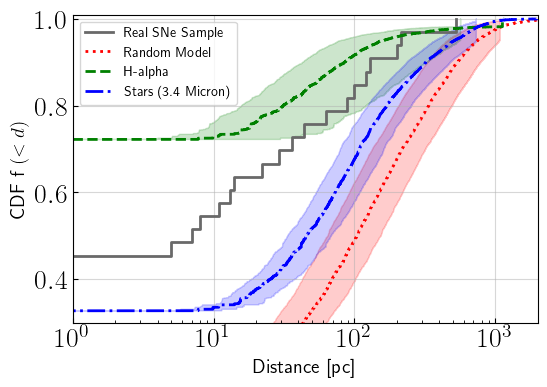

In [11]:
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(6,4))

# ax.plot(mod2, ymod2, label="Hybrid (76% gas + 24% stars)", color='purple', ls="-",lw=2)
sns.ecdfplot(realSNe, color = "dimgrey",  label="Real SNe Sample", ax=ax,lw=2)
sns.ecdfplot(nm1, label="Random Model", color='red', ls=":",ax=ax,lw=2)
sns.ecdfplot(nm2, label="H-alpha", color='green', ls="--",lw=2,ax=ax)
sns.ecdfplot(nm3, label="Stars (3.4 Micron)", color='blue', ls="-.",lw=2,ax=ax)
# ax[0].plot(mod4, ymod4, label="Hybrid (76% gas + 24% stars)", color='purple', ls="-",lw=2)
# ax.plot(mod2, ymod2, label="H-alpha", color='green', ls="--",lw=2)
ax.fill_between(x=mod1_50, y1=ymod1_16,y2=ymod1_84, color='red', alpha=0.2)
ax.fill_between(x=mod2_50, y1=ymod2_16,y2=ymod2_84, color='green', alpha=0.2)
# ax.fill_between(x=mod2_50, y1=ymod2_50,y2=ymod2_84, color='green', alpha=0.2)
ax.fill_between(x=mod3_50, y1=ymod3_16,y2=ymod3_84, color='blue', alpha=0.2)
# ax[0].fill_between(x=mod4_50, y1=ymod4_16,y2=ymod4_84, color='purple', alpha=0.2)
ax.set_xscale('log')
ax.set_ylim (0.3,1.01)
ax.set_xlim(1,2000)
ax.legend(loc='best')

# sns.ecdfplot(nSMIa,color = "black", ls=':', label="Real SNe Ia", ax=ax[1],lw=2)
# sns.ecdfplot(nSMII,color = "black", ls='-',  label="Real SNe II", ax=ax[1],lw=2)
# sns.ecdfplot(nSMIbc,color = "black", ls='--',  label="Real SNe Ibc", ax=ax[1],lw=2)
# sns.ecdfplot(nSMunc,color = "black", ls='-.',  label="Real Unclassified", ax=ax[1],lw=2)

# ax[1].plot(mod1, ymod1, color='red', ls=":",lw=2)
# ax[1].plot(mod2, ymod2, color='green', ls="--",lw=2)
# ax[1].plot(mod3, ymod3, color='blue', ls="-.",lw=2)
# # ax[1].plot(mod4, ymod4, color='purple', ls="-",lw=2)
# ax[1].fill_between(x=mod1_50, y1=ymod1_16,y2=ymod1_84, color='red', alpha=0.2)
# ax[1].fill_between(x=mod2_50, y1=ymod2_16,y2=ymod2_84, color='green', alpha=0.2)
# ax[1].fill_between(x=mod3_50, y1=ymod3_16,y2=ymod3_84, color='blue', alpha=0.2)
# # ax[1].fill_between(x=mod4_50, y1=ymod4_16,y2=ymod4_84, color='purple', alpha=0.2)
# ax[1].set_xscale('log')
# ax[1].set_ylim (0.3,1.01)
# ax[1].set_xlim(60,5000)

# ax[1].legend(loc='best')

ax.tick_params(axis = "both", which = "both", direction = "in")
# ax[1].tick_params(axis = "both", which = "both", direction = "in")

plt.xlabel("Distance [pc]", fontsize = 14)
ax.set_ylabel(r"CDF f $(< d)$", fontsize = 14)
# ax[1].set_ylabel("CDF f (< d)", fontsize = 14)
ax.grid(which='major', alpha=0.5)
# ax[1].grid(which='major', alpha=0.5)
fig.savefig("../Figures/DistanceCDF.png", dpi=300)
plt.show()
plt.close()

In [12]:
realSNeInt = database["Intensity"]/intScale
SNe,  ySNe  = ecdf(realSNeInt)
SNe = SNe/intScale
mod1, ymod1 = makeCDFs(im1)
mod2, ymod2 = makeCDFs(im2)
mod3, ymod3 = makeCDFs(im3)

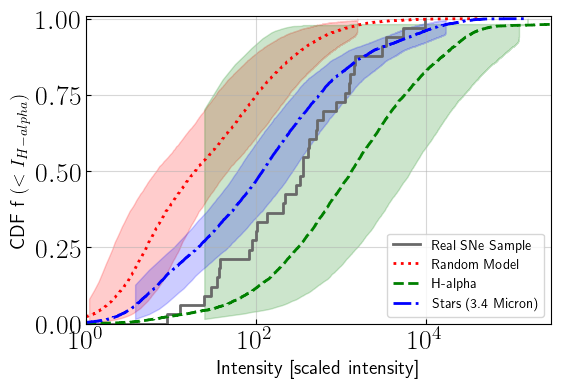

In [13]:

import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(6,4))

sns.ecdfplot(realSNeInt, color = "dimgrey",  label="Real SNe Sample", ax=ax,lw=2)
sns.ecdfplot(im1, label="Random Model", color='red', ls=":",ax=ax,lw=2)
sns.ecdfplot(im2, label="H-alpha", color='green', ls="--",lw=2,ax=ax)
sns.ecdfplot(im3, label="Stars (3.4 Micron)", color='blue', ls="-.",lw=2,ax=ax)
# ax[0].plot(mod4, ymod4, label="Hybrid (76% gas + 24% stars)", color='purple', ls="-",lw=2)
# ax.plot(mod2, ymod2, label="H-alpha", color='green', ls="--",lw=2)
ax.fill_between(x=imod1_50, y1=iymod1_16,y2=iymod1_84, color='red', alpha=0.2)
ax.fill_between(x=imod2_50, y1=iymod2_16,y2=iymod2_84, color='green', alpha=0.2)
# ax.fill_between(x=mod2_50, y1=ymod2_50,y2=ymod2_84, color='green', alpha=0.2)
ax.fill_between(x=imod3_50, y1=iymod3_16,y2=iymod3_84, color='blue', alpha=0.2)
# ax[0].fill_between(x=mod4_50, y1=ymod4_16,y2=ymod4_84, color='purple', alpha=0.2)
ax.set_xscale('log')
ax.set_ylim (0.,1.01)
ax.set_xlim(1,300000)
ax.legend(loc='best')

ax.tick_params(axis = "both", which = "both", direction = "in")
# ax[1].tick_params(axis = "both", which = "both", direction = "in")

plt.xlabel("Intensity [scaled intensity]", fontsize = 14)
ax.set_ylabel(r"CDF f $(< I_{H-alpha})$", fontsize = 14)
# ax[1].set_ylabel("CDF f (< d)", fontsize = 14)
ax.grid(which='major', alpha=0.5)
# ax[1].grid(which='major', alpha=0.5)
fig.savefig("../Figures/IntensitiesCDF.png", dpi=300)
plt.show()
plt.close()

In [14]:
len(im2)

10000

In [15]:
imod2_50

array([2.46871877e+01, 4.05905761e+01, 5.64939645e+01, ...,
       1.59010861e+05, 1.59026764e+05, 1.59042668e+05])

In [16]:
iymod2_50

array([0.0433, 0.0584, 0.0751, ..., 0.9822, 0.9822, 1.    ])

In [17]:
iymod2_16[0:10]

array([0.0153, 0.0236, 0.0292, 0.0333, 0.0382, 0.0411, 0.0441, 0.047 ,
       0.0499, 0.0538])

In [18]:
iymod2_84[0:10]

array([0.7035, 0.8006, 0.8502, 0.879 , 0.9032, 0.9209, 0.936 , 0.9457,
       0.9547, 0.9603])

In [19]:
imod2_50

array([2.46871877e+01, 4.05905761e+01, 5.64939645e+01, ...,
       1.59010861e+05, 1.59026764e+05, 1.59042668e+05])

In [20]:
print(np.average(iSMm2_16), np.average(iSMm2_50), np.average(iSMm2_84))

5134.438296645754 8022.715997083395 733623.9386975854
